In [ ]:
# 1. Import Libraries and Load Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K

In [5]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
# 2. Autoencoder Architecture

In [6]:
# Define autoencoder architecture
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# Create autoencoder model
autoencoder = Model(input_img, decoded)

# Compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [7]:
# 3. Train Autoencoder

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/50
235/235 [==============================] - 4s 15ms/step - loss: 0.2139 - val_loss: 0.1344
Epoch 2/50
235/235 [==============================] - 3s 14ms/step - loss: 0.1176 - val_loss: 0.1031
Epoch 3/50
235/235 [==============================] - 4s 18ms/step - loss: 0.0967 - val_loss: 0.0894
Epoch 4/50
235/235 [==============================] - 4s 16ms/step - loss: 0.0862 - val_loss: 0.0815
Epoch 5/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0801 - val_loss: 0.0772
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0764 - val_loss: 0.0743
Epoch 7/50
235/235 [==============================] - 4s 19ms/step - loss: 0.0740 - val_loss: 0.0725
Epoch 8/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0724 - val_loss: 0.0712
Epoch 9/50
235/235 [==============================] - 3s 14ms/step - loss: 0.0712 - val_loss: 0.0702
Epoch 10/50
235/235 [==============================] - 4s 18ms/step - loss: 0.0703 - val_lo

In [9]:
# 4. Variational Autoencoder Architecture

In [10]:
# Define VAE architecture
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
z_mean = Dense(2)(encoded)
z_log_var = Dense(2)(encoded)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder layers
decoded_layer = Dense(128, activation='relu')
decoded = decoded_layer(z)
decoded_output = Dense(784, activation='sigmoid')(decoded)

# Create VAE model
vae = Model(input_img, decoded_output)

# Loss
reconstruction_loss = keras.losses.binary_crossentropy(input_img, decoded_output)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile VAE
vae.compile(optimizer='adam')

In [11]:
# 5. Train Variational Autoencoder

In [15]:
# Train VAE
history = vae.fit(x_train,
                   epochs=50,
                   batch_size=256,
                   validation_data=(x_test, None))


Epoch 1/50
235/235 [==============================] - 4s 15ms/step - loss: 152.3143 - val_loss: 154.4010
Epoch 2/50
235/235 [==============================] - 5s 19ms/step - loss: 152.2655 - val_loss: 154.4805
Epoch 3/50
235/235 [==============================] - 3s 15ms/step - loss: 152.1086 - val_loss: 154.3774
Epoch 4/50
235/235 [==============================] - 4s 15ms/step - loss: 151.9395 - val_loss: 154.1039
Epoch 5/50
235/235 [==============================] - 4s 19ms/step - loss: 151.8824 - val_loss: 154.2479
Epoch 6/50
235/235 [==============================] - 4s 15ms/step - loss: 151.7814 - val_loss: 154.0596
Epoch 7/50
235/235 [==============================] - 4s 15ms/step - loss: 151.6456 - val_loss: 154.0131
Epoch 8/50
235/235 [==============================] - 4s 16ms/step - loss: 151.5501 - val_loss: 153.9486
Epoch 9/50
235/235 [==============================] - 4s 18ms/step - loss: 151.4662 - val_loss: 154.0424
Epoch 10/50
235/235 [==============================] - 

In [13]:
# 6. Evaluation and Visualization

In [27]:
# Define function to calculate KL divergence
def kl_divergence_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return kl_loss

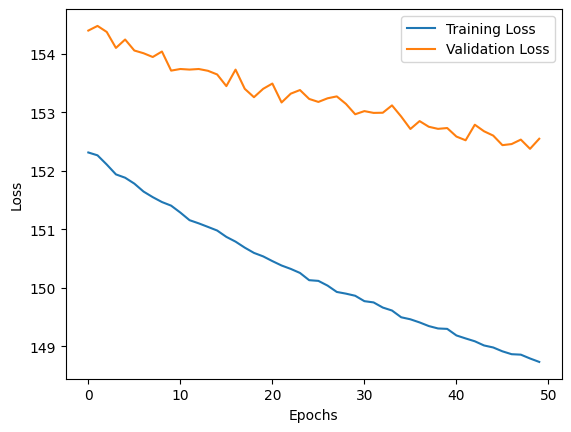

In [28]:
# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 [==============================] - 1s 2ms/step


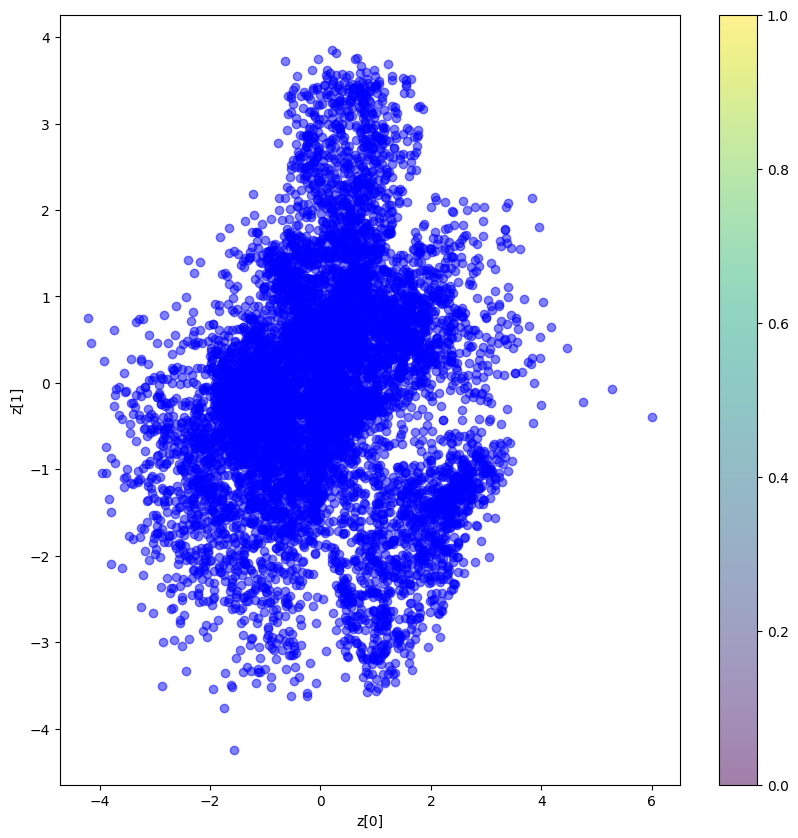

In [29]:
# Plot latent space
encoder = Model(input_img, z_mean)
encoded_imgs = encoder.predict(x_test)

plt.figure(figsize=(10, 10))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c='b', alpha=0.5)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()
